# Double Machine Learning (DML) for Tax Software Impact Analysis

This notebook demonstrates **Double Machine Learning (DML)** to estimate the causal effect of the Smart Filing Assistant on user conversion rates.

## 🎯 What is Double Machine Learning?

DML combines the best of machine learning and causal inference:

1. **Outcome Model**: ML model to predict outcomes given covariates
2. **Treatment Model**: ML model to predict treatment propensity given covariates  
3. **Cross-fitting**: Sample splitting to avoid overfitting bias
4. **Orthogonal Moments**: Debiased estimation that's robust to model misspecification

### Key Advantages:
- **Robust**: Works well even if one of the two models is misspecified
- **Flexible**: Can use any ML algorithm (Random Forest, Gradient Boosting, etc.)
- **Unbiased**: Cross-fitting eliminates overfitting bias
- **High-dimensional**: Handles many covariates effectively

### Business Question:
**What is the true causal effect of the Smart Filing Assistant on tax filing rates, accounting for complex user characteristics and selection bias?**


In [1]:
# Import required libraries
import os
import sys

sys.path.append(os.path.abspath('..'))

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.causal_methods.dml import DoubleMachineLearning
from src.data_simulation import generate_and_save_data

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("📚 Libraries imported successfully!")


📚 Libraries imported successfully!


## 🏗️ Step 1: Generate and Explore Data


In [2]:
# Generate synthetic tax software data
print("🎲 Generating synthetic tax software data...")
df = generate_and_save_data(
    output_path='../data/tax_software_dml_demo.csv',
    n_users=2000,  # Larger sample for DML
    config_path='../config/simulation_config.yaml'
)

print(f"✅ Generated dataset with {len(df)} users")
print(f"📊 Treatment adoption rate: {df['used_smart_assistant'].mean():.1%}")
print(f"📈 Overall filing rate: {df['filed_2024'].mean():.1%}")

# Display first few rows
df.head()


🎲 Generating synthetic tax software data...
Generating user demographics...
Generating 2023 baseline data...
Generating treatment assignment...
Generating 2024 outcomes...
Generated dataset with 2000 users
Treatment rate: 63.45%
2024 filing rate: 91.45%

Dataset saved to ../data/tax_software_dml_demo.csv

DATASET SUMMARY
Total users: 2,000
Treatment rate: 63.4%
2023 filing rate: 83.0%
2024 filing rate: 91.5%

Treated group filing rate: 94.3%
Control group filing rate: 86.5%
Naive treatment effect: 7.9%
✅ Generated dataset with 2000 users
📊 Treatment adoption rate: 63.4%
📈 Overall filing rate: 91.5%


,user_id,age,income_bracket,device_type,user_type,region,tech_savviness,filed_2023,time_to_complete_2023,sessions_2023,support_tickets_2023,early_login_2024,used_smart_assistant,filed_2024,time_to_complete_2024,sessions_2024,support_tickets_2024,satisfaction_2024,time_improvement,session_improvement
0,user_000000,41,50k-75k,tablet,returning,Midwest,41,False,0,0,0,False,True,True,90,1,0,7.763753,-90,-1
1,user_000001,37,<30k,desktop,returning,Midwest,43,False,0,0,0,False,True,True,81,1,0,6.193148,-81,-1
2,user_000002,19,30k-50k,mobile,new,East,61,False,0,0,0,False,True,True,93,1,0,9.587250,-93,-1
3,user_000003,66,75k-100k,mobile,new,East,31,True,118,2,0,False,True,True,102,1,0,8.104232,16,1
4,user_000004,27,30k-50k,desktop,returning,West,85,True,31,1,0,True,True,True,28,2,0,7.268665,3,-1


In [3]:
# Explore the data structure
print("📋 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\n📊 Summary Statistics:")
print(df[['age', 'tech_savviness', 'used_smart_assistant', 'filed_2024', 'satisfaction_2024']].describe())


📋 Dataset Overview:
Shape: (2000, 20)
Columns: ['user_id', 'age', 'income_bracket', 'device_type', 'user_type', 'region', 'tech_savviness', 'filed_2023', 'time_to_complete_2023', 'sessions_2023', 'support_tickets_2023', 'early_login_2024', 'used_smart_assistant', 'filed_2024', 'time_to_complete_2024', 'sessions_2024', 'support_tickets_2024', 'satisfaction_2024', 'time_improvement', 'session_improvement']

📊 Summary Statistics:
               age  tech_savviness  satisfaction_2024
count  2000.000000     2000.000000        1829.000000
mean     44.569000       53.075500           7.712474
std      14.158618       21.400182           1.251266
min      18.000000        0.000000           3.565536
25%      34.000000       38.000000           6.868967
50%      44.000000       52.000000           7.758210
75%      55.000000       68.000000           8.613642
max      80.000000      100.000000          10.000000


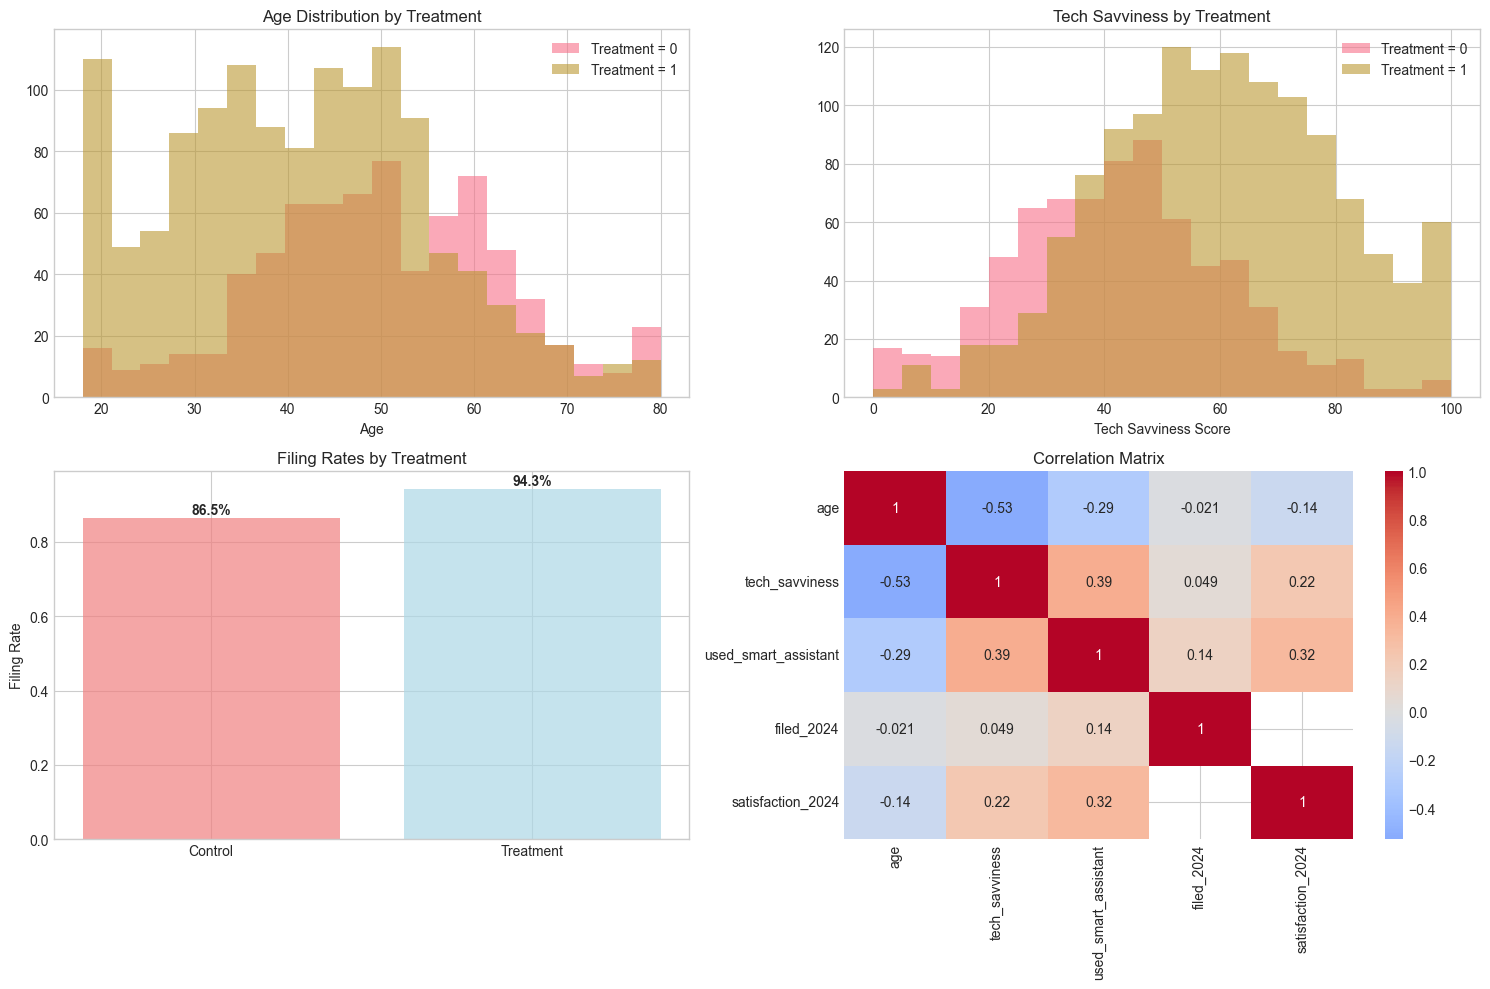


🎯 Naive Treatment Effect: 0.0787 (7.9%)
⚠️  This estimate may be biased due to selection effects!


In [4]:
# Visualize selection bias
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution by treatment
for treatment in [0, 1]:
    subset = df[df['used_smart_assistant'] == treatment]
    axes[0, 0].hist(subset['age'], alpha=0.6, label=f'Treatment = {treatment}', bins=20)
axes[0, 0].set_title('Age Distribution by Treatment')
axes[0, 0].set_xlabel('Age')
axes[0, 0].legend()

# Tech savviness by treatment
for treatment in [0, 1]:
    subset = df[df['used_smart_assistant'] == treatment]
    axes[0, 1].hist(subset['tech_savviness'], alpha=0.6, label=f'Treatment = {treatment}', bins=20)
axes[0, 1].set_title('Tech Savviness by Treatment')
axes[0, 1].set_xlabel('Tech Savviness Score')
axes[0, 1].legend()

# Filing rates by treatment
filing_by_treatment = df.groupby('used_smart_assistant')['filed_2024'].mean()
axes[1, 0].bar(['Control', 'Treatment'], filing_by_treatment.values,
               color=['lightcoral', 'lightblue'], alpha=0.7)
axes[1, 0].set_title('Filing Rates by Treatment')
axes[1, 0].set_ylabel('Filing Rate')
for i, v in enumerate(filing_by_treatment.values):
    axes[1, 0].text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

# Correlation heatmap of key variables
corr_vars = ['age', 'tech_savviness', 'used_smart_assistant', 'filed_2024', 'satisfaction_2024']
corr_matrix = df[corr_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Calculate naive treatment effect
naive_effect = df[df['used_smart_assistant'] == 1]['filed_2024'].mean() - df[df['used_smart_assistant'] == 0]['filed_2024'].mean()
print(f"\n🎯 Naive Treatment Effect: {naive_effect:.4f} ({naive_effect:.1%})")
print("⚠️  This estimate may be biased due to selection effects!")


## 🔬 Step 2: Define Variables and Setup DML


In [5]:
# Define variables for DML analysis
treatment_col = 'used_smart_assistant'
outcome_cols = ['filed_2024', 'satisfaction_2024']  # Multiple outcomes

# Select numeric covariates (potential confounders)
# For DML with scaling, we need numeric variables only
numeric_covariates = [
    'age', 'tech_savviness', 'filed_2023', 'early_login_2024'
]

# Verify all covariates are numeric
for col in numeric_covariates:
    if col in df.columns:
        print(f"✅ {col}: {df[col].dtype}")
    else:
        print(f"❌ {col}: Not found in dataset")

print(f"\n🎯 Treatment variable: {treatment_col}")
print(f"📊 Outcome variables: {outcome_cols}")
print(f"🔧 Numeric covariates ({len(numeric_covariates)}): {numeric_covariates}")

# Initialize DML
dml = DoubleMachineLearning(df, random_state=42)
print("\n✅ DML initialized successfully!")


✅ age: int64
✅ tech_savviness: int64
✅ filed_2023: bool
✅ early_login_2024: bool

🎯 Treatment variable: used_smart_assistant
📊 Outcome variables: ['filed_2024', 'satisfaction_2024']
🔧 Numeric covariates (4): ['age', 'tech_savviness', 'filed_2023', 'early_login_2024']

✅ DML initialized successfully!


## 🎯 Step 3: Estimate Treatment Effects with DML

We'll use Random Forest models for both outcome and treatment prediction, with 3-fold cross-fitting.


In [6]:
# Estimate treatment effects for primary outcome (filing rate)
print("🚀 Estimating treatment effects using DML...")
print("📊 Primary Outcome: Filed 2024")

filing_results = dml.estimate_treatment_effects(
    outcome_col='filed_2024',
    treatment_col=treatment_col,
    covariates=numeric_covariates,
    outcome_model='random_forest',
    treatment_model='random_forest',
    n_folds=3,
    scale_features=True
)

print("\n🎯 DML Results for Filing Rate:")
print(f"Average Treatment Effect: {filing_results['ate']:.4f} ({filing_results['ate']:.1%})")
print(f"Standard Error: {filing_results['se']:.4f}")
print(f"95% Confidence Interval: [{filing_results['ci_lower']:.4f}, {filing_results['ci_upper']:.4f}]")
print(f"P-value: {filing_results['p_value']:.6f}")

if filing_results['p_value'] < 0.05:
    print("\n✅ STATISTICALLY SIGNIFICANT at 5% level")
else:
    print("\n❌ Not statistically significant at 5% level")

print(f"\nSample size: {filing_results['n_samples']}")
print(f"Cross-fitting folds: {filing_results['n_folds']}")


🚀 Estimating treatment effects using DML...
📊 Primary Outcome: Filed 2024

🎯 DML Results for Filing Rate:
Average Treatment Effect: 0.1001 (10.0%)
Standard Error: 0.0149
95% Confidence Interval: [0.0708, 0.1293]
P-value: 0.000000

✅ STATISTICALLY SIGNIFICANT at 5% level

Sample size: 2000
Cross-fitting folds: 3


In [7]:
# Estimate effects for secondary outcome (satisfaction)
print("📊 Secondary Outcome: Satisfaction 2024")

satisfaction_results = dml.estimate_treatment_effects(
    outcome_col='satisfaction_2024',
    treatment_col=treatment_col,
    covariates=numeric_covariates,
    outcome_model='random_forest',
    treatment_model='random_forest',
    n_folds=3,
    scale_features=True
)

print("\n🎯 DML Results for Satisfaction:")
print(f"Average Treatment Effect: {satisfaction_results['ate']:.4f}")
print(f"Standard Error: {satisfaction_results['se']:.4f}")
print(f"95% Confidence Interval: [{satisfaction_results['ci_lower']:.4f}, {satisfaction_results['ci_upper']:.4f}]")
print(f"P-value: {satisfaction_results['p_value']:.6f}")

if satisfaction_results['p_value'] < 0.05:
    print("\n✅ STATISTICALLY SIGNIFICANT at 5% level")
else:
    print("\n❌ Not statistically significant at 5% level")


📊 Secondary Outcome: Satisfaction 2024

🎯 DML Results for Satisfaction:
Average Treatment Effect: 0.6566
Standard Error: 0.0685
95% Confidence Interval: [0.5223, 0.7910]
P-value: 0.000000

✅ STATISTICALLY SIGNIFICANT at 5% level


## 📊 Step 4: Model Performance and Diagnostics


In [8]:
# Display model performance across folds with information criteria
print("🔍 Model Performance Diagnostics (Information Criteria):")
print("=" * 60)

for outcome in ['filed_2024', 'satisfaction_2024']:
    if outcome in dml.treatment_effects:
        results = dml.treatment_effects[outcome]
        print(f"\n📊 {outcome.upper()}")
        print("-" * 40)

        # Calculate average performance across folds
        outcome_aic_scores = []
        outcome_bic_scores = []
        outcome_traditional_scores = []
        treatment_aic_scores = []
        treatment_bic_scores = []
        treatment_auc_scores = []

        for fold_data in results['fold_performance']:
            fold_num = fold_data['fold']

            # Outcome model performance
            outcome_perf = fold_data['outcome_performance']

            # Extract information criteria for outcome model
            if 'aic' in outcome_perf and not np.isnan(outcome_perf['aic']):
                outcome_aic_scores.append(outcome_perf['aic'])
                print(f"  Fold {fold_num}: Outcome AIC = {outcome_perf['aic']:.2f}")

            if 'bic' in outcome_perf and not np.isnan(outcome_perf['bic']):
                outcome_bic_scores.append(outcome_perf['bic'])
                print(f"                Outcome BIC = {outcome_perf['bic']:.2f}")

            # Also track traditional metrics for comparison
            if results['outcome_is_binary']:
                if 'auc' in outcome_perf and not np.isnan(outcome_perf['auc']):
                    outcome_traditional_scores.append(outcome_perf['auc'])
                    print(f"                Outcome AUC = {outcome_perf['auc']:.3f}")
            else:
                if 'r2' in outcome_perf and not np.isnan(outcome_perf['r2']):
                    outcome_traditional_scores.append(outcome_perf['r2'])
                    print(f"                Outcome R² = {outcome_perf['r2']:.3f}")

            # Treatment model performance
            treatment_perf = fold_data['treatment_performance']

            # Extract information criteria for treatment model
            if 'aic' in treatment_perf and not np.isnan(treatment_perf['aic']):
                treatment_aic_scores.append(treatment_perf['aic'])
                print(f"                Treatment AIC = {treatment_perf['aic']:.2f}")

            if 'bic' in treatment_perf and not np.isnan(treatment_perf['bic']):
                treatment_bic_scores.append(treatment_perf['bic'])
                print(f"                Treatment BIC = {treatment_perf['bic']:.2f}")

            if 'auc' in treatment_perf and not np.isnan(treatment_perf['auc']):
                treatment_auc_scores.append(treatment_perf['auc'])
                print(f"                Treatment AUC = {treatment_perf['auc']:.3f}")

            print()  # Add spacing between folds

        # Summary statistics - prioritize information criteria
        print("📈 SUMMARY STATISTICS:")

        if outcome_aic_scores:
            print(f"  Average Outcome AIC: {np.mean(outcome_aic_scores):.2f} (±{np.std(outcome_aic_scores):.2f})")

        if outcome_bic_scores:
            print(f"  Average Outcome BIC: {np.mean(outcome_bic_scores):.2f} (±{np.std(outcome_bic_scores):.2f})")

        if treatment_aic_scores:
            print(f"  Average Treatment AIC: {np.mean(treatment_aic_scores):.2f} (±{np.std(treatment_aic_scores):.2f})")

        if treatment_bic_scores:
            print(f"  Average Treatment BIC: {np.mean(treatment_bic_scores):.2f} (±{np.std(treatment_bic_scores):.2f})")

        # Traditional metrics as secondary information
        if outcome_traditional_scores:
            metric_name = "AUC" if results['outcome_is_binary'] else "R²"
            print(f"  Average Outcome {metric_name}: {np.mean(outcome_traditional_scores):.3f} (±{np.std(outcome_traditional_scores):.3f})")

        if treatment_auc_scores:
            print(f"  Average Treatment AUC: {np.mean(treatment_auc_scores):.3f} (±{np.std(treatment_auc_scores):.3f})")

        print("\n  💡 Information Criteria Interpretation:")
        print("     • Lower AIC/BIC values = Better model quality")
        print("     • AIC: Balances fit vs complexity (favors prediction)")
        print("     • BIC: Stronger complexity penalty (favors parsimony)")
        print("     • Good information criteria → reliable causal estimates!")
        print("  ✅ Information criteria provide theoretically grounded model comparison")


🔍 Model Performance Diagnostics (Information Criteria):

📊 FILED_2024
----------------------------------------
  Fold 0: Outcome AIC = 20659.11
                Outcome BIC = 73857.83
                Outcome AUC = 0.515
                Treatment AIC = 20939.23
                Treatment BIC = 74137.95
                Treatment AUC = 0.662

  Fold 1: Outcome AIC = 20652.61
                Outcome BIC = 73851.32
                Outcome AUC = 0.508
                Treatment AIC = 20964.76
                Treatment BIC = 74163.48
                Treatment AUC = 0.722

  Fold 2: Outcome AIC = 20693.77
                Outcome BIC = 73900.17
                Outcome AUC = 0.610
                Treatment AIC = 20960.34
                Treatment BIC = 74166.74
                Treatment AUC = 0.712

📈 SUMMARY STATISTICS:
  Average Outcome AIC: 20668.50 (±18.07)
  Average Outcome BIC: 73869.77 (±21.66)
  Average Treatment AIC: 20954.78 (±11.14)
  Average Treatment BIC: 74156.06 (±12.87)
  Average Ou

📈 Visualizing Model Residuals:


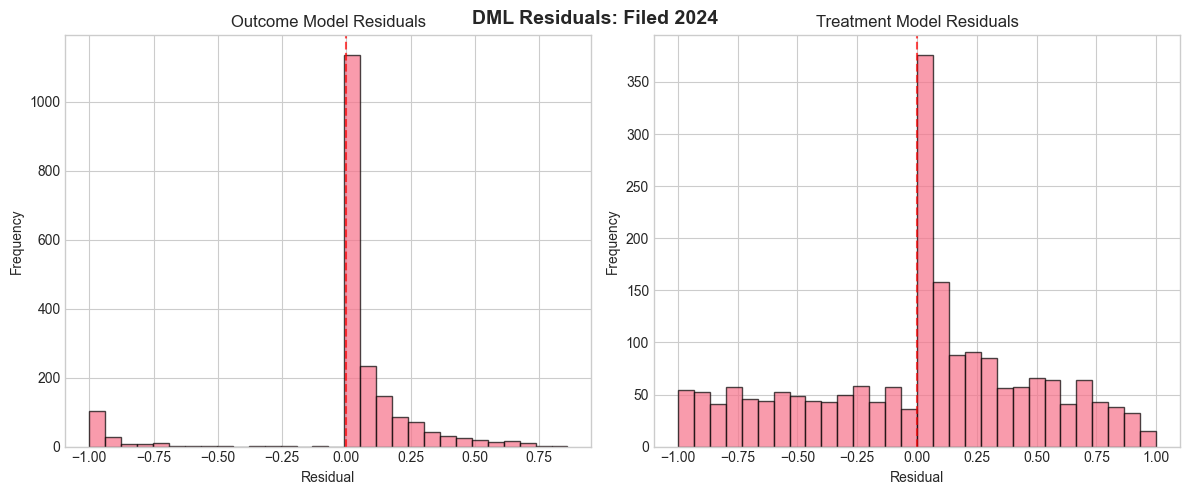

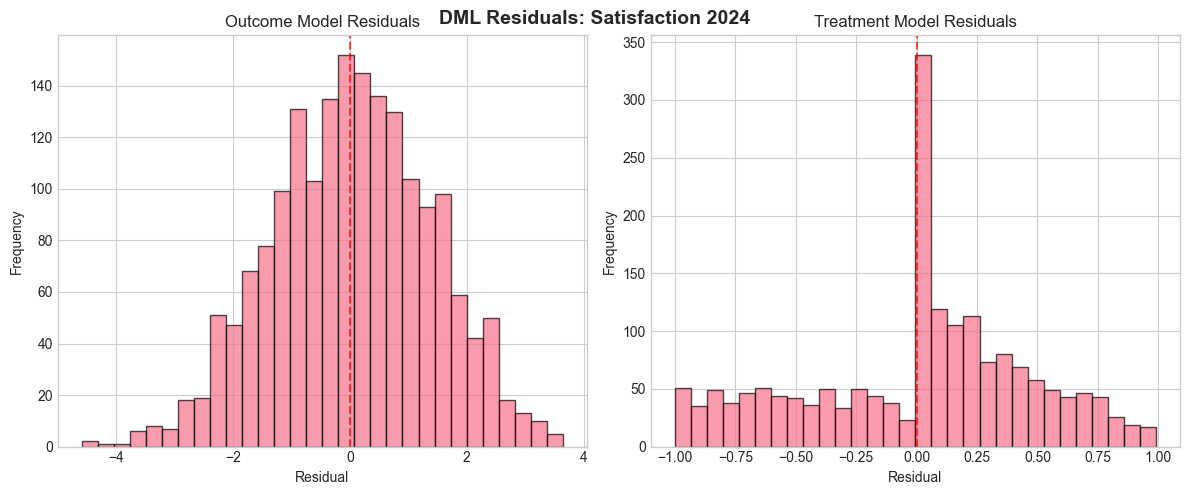


🔍 Residual Interpretation:
• Outcome residuals: Difference between actual and predicted outcomes
• Treatment residuals: Difference between actual and predicted treatment
• Well-centered distributions around 0 indicate good model fit


In [9]:
# Plot residuals to check model fit
print("📈 Visualizing Model Residuals:")

fig_filing = dml.plot_residuals('filed_2024', figsize=(12, 5))
fig_filing.suptitle('DML Residuals: Filed 2024', fontsize=14, fontweight='bold')
plt.show()

fig_satisfaction = dml.plot_residuals('satisfaction_2024', figsize=(12, 5))
fig_satisfaction.suptitle('DML Residuals: Satisfaction 2024', fontsize=14, fontweight='bold')
plt.show()

print("\n🔍 Residual Interpretation:")
print("• Outcome residuals: Difference between actual and predicted outcomes")
print("• Treatment residuals: Difference between actual and predicted treatment")
print("• Well-centered distributions around 0 indicate good model fit")


## 🔄 Step 5: Model Comparison and Robustness

Let's compare different ML models to check robustness of our results.


In [10]:
# Compare different ML models for robustness
print("🔄 Comparing Different ML Models for Robustness:")
print("=" * 60)

comparison_results = dml.compare_models(
    outcome_col='filed_2024',
    treatment_col=treatment_col,
    covariates=numeric_covariates,
    n_folds=3,
    scale_features=True
)

# Display comparison table with information criteria highlighted
print("\n📊 Model Comparison Results:")
print(comparison_results.round(4))

# Highlight information criteria analysis
if 'aic' in comparison_results.columns and 'bic' in comparison_results.columns:
    print("\n🔍 Information Criteria Analysis:")
    print("=" * 50)

    # Find best models according to information criteria
    best_aic_idx = comparison_results['aic'].idxmin()
    best_bic_idx = comparison_results['bic'].idxmin()

    print("🏆 Best AIC Model:")
    best_aic_row = comparison_results.loc[best_aic_idx]
    print(f"   • Model: {best_aic_row['outcome_model']} + {best_aic_row['treatment_model']}")
    print(f"   • AIC: {best_aic_row['aic']:.2f}")
    print(f"   • ATE: {best_aic_row['ate']:.4f}")

    print("\n🏆 Best BIC Model:")
    best_bic_row = comparison_results.loc[best_bic_idx]
    print(f"   • Model: {best_bic_row['outcome_model']} + {best_bic_row['treatment_model']}")
    print(f"   • BIC: {best_bic_row['bic']:.2f}")
    print(f"   • ATE: {best_bic_row['ate']:.4f}")

    # Information criteria statistics
    aic_mean = comparison_results['aic'].mean()
    aic_std = comparison_results['aic'].std()
    bic_mean = comparison_results['bic'].mean()
    bic_std = comparison_results['bic'].std()

    print("\n📈 Information Criteria Statistics:")
    print(f"   • Average AIC: {aic_mean:.2f} (±{aic_std:.2f})")
    print(f"   • Average BIC: {bic_mean:.2f} (±{bic_std:.2f})")
    print(f"   • AIC Range: [{comparison_results['aic'].min():.2f}, {comparison_results['aic'].max():.2f}]")
    print(f"   • BIC Range: [{comparison_results['bic'].min():.2f}, {comparison_results['bic'].max():.2f}]")

# Calculate ATE statistics
ate_mean = comparison_results['ate'].mean()
ate_std = comparison_results['ate'].std()
ate_min = comparison_results['ate'].min()
ate_max = comparison_results['ate'].max()

print("\n📈 ATE Statistics Across Models:")
print(f"Mean: {ate_mean:.4f}")
print(f"Std Dev: {ate_std:.4f}")
print(f"Range: [{ate_min:.4f}, {ate_max:.4f}]")
print(f"Coefficient of Variation: {ate_std/abs(ate_mean):.2%}")

if ate_std/abs(ate_mean) < 0.1:
    print("\n✅ Results are ROBUST across different model specifications!")
else:
    print("\n⚠️  Results show some sensitivity to model choice - interpret carefully")


🔄 Comparing Different ML Models for Robustness:

📊 Model Comparison Results:
          outcome_model      treatment_model     ate      se  p_value  \
0         random_forest        random_forest  0.1001  0.0149   0.0000   
1         random_forest    gradient_boosting  0.0926  0.0163   0.0000   
2         random_forest  logistic_regression  0.0977  0.0169   0.0000   
3         random_forest     ridge_classifier  0.0588  0.0134   0.0000   
4     gradient_boosting        random_forest  0.0827  0.0140   0.0000   
5     gradient_boosting    gradient_boosting  0.0828  0.0151   0.0000   
6     gradient_boosting  logistic_regression  0.0876  0.0157   0.0000   
7     gradient_boosting     ridge_classifier  0.0491  0.0122   0.0001   
8   logistic_regression        random_forest  0.0776  0.0133   0.0000   
9   logistic_regression    gradient_boosting  0.0787  0.0143   0.0000   
10  logistic_regression  logistic_regression  0.0838  0.0148   0.0000   
11  logistic_regression     ridge_classifier  0

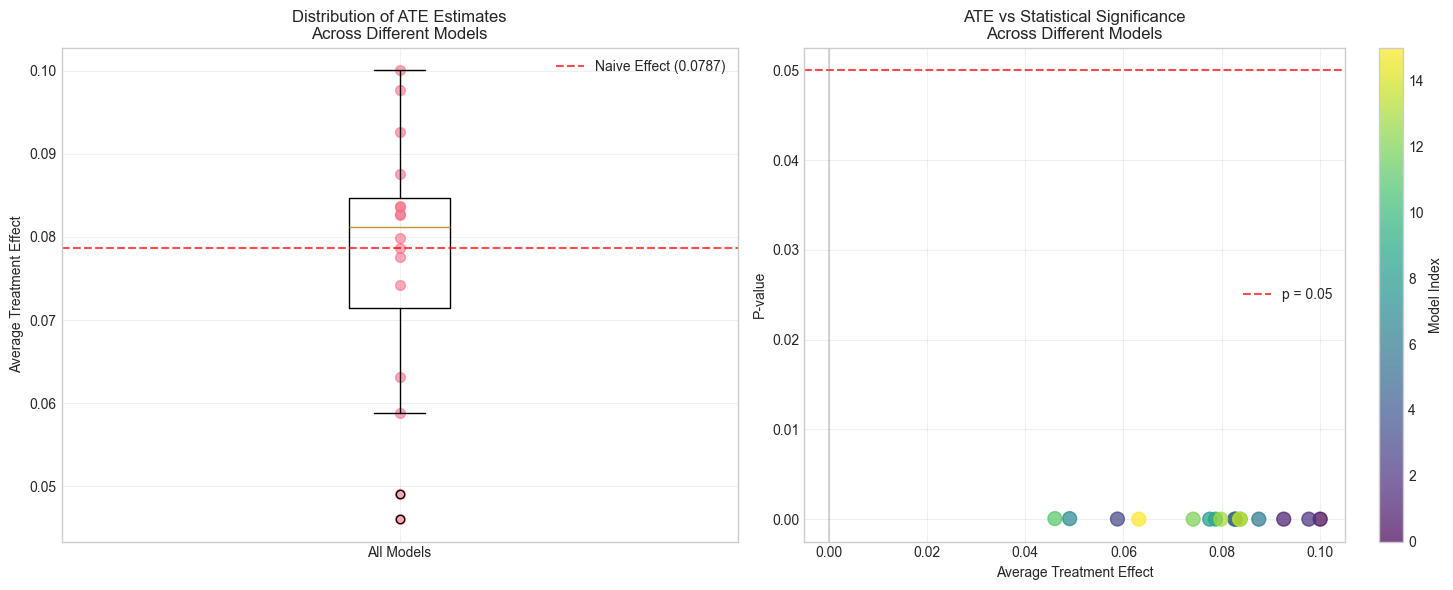

In [11]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of ATEs across models
axes[0].boxplot(comparison_results['ate'], labels=['All Models'])
axes[0].scatter([1] * len(comparison_results), comparison_results['ate'], alpha=0.6, s=50)
axes[0].axhline(naive_effect, color='red', linestyle='--', alpha=0.7, label=f'Naive Effect ({naive_effect:.4f})')
axes[0].set_title('Distribution of ATE Estimates\nAcross Different Models')
axes[0].set_ylabel('Average Treatment Effect')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot: ATE vs P-value
scatter = axes[1].scatter(comparison_results['ate'], comparison_results['p_value'],
                         alpha=0.7, s=100, c=comparison_results.index, cmap='viridis')
axes[1].axhline(0.05, color='red', linestyle='--', alpha=0.7, label='p = 0.05')
axes[1].axvline(0, color='gray', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Average Treatment Effect')
axes[1].set_ylabel('P-value')
axes[1].set_title('ATE vs Statistical Significance\nAcross Different Models')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Model Index')

plt.tight_layout()
plt.show()


## 📊 Step 6: Final Results Visualization


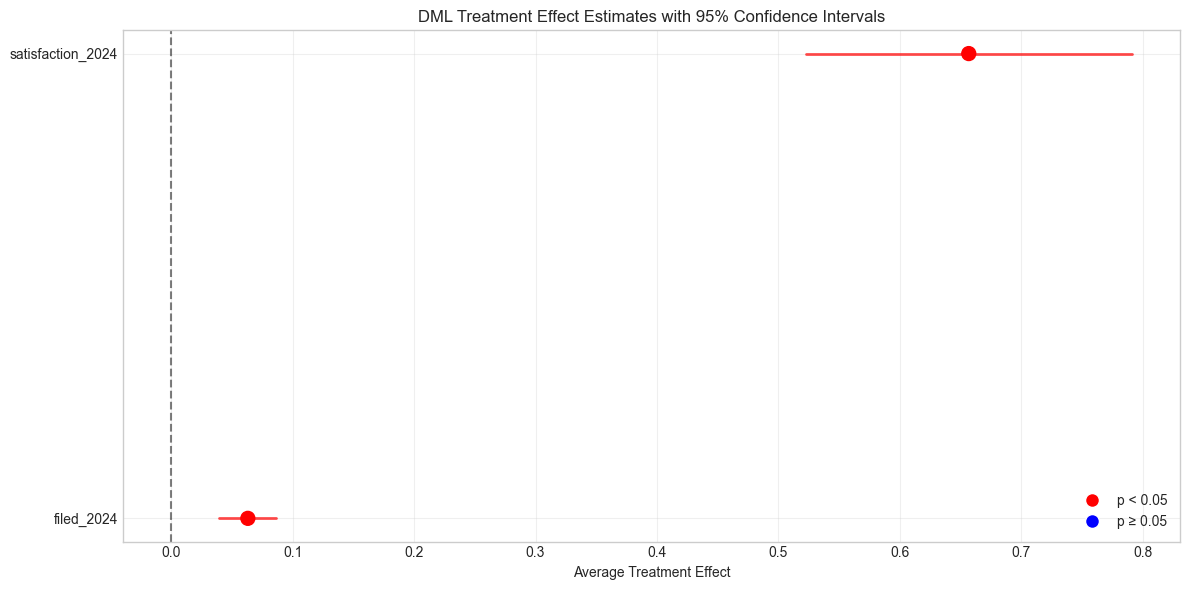


COMPREHENSIVE DML ANALYSIS SUMMARY
DOUBLE MACHINE LEARNING RESULTS

Outcome: filed_2024
------------------------------
Average Treatment Effect: 0.0631
Standard Error: 0.0119
95% Confidence Interval: [0.0398, 0.0865]
P-value: 0.0000
*** STATISTICALLY SIGNIFICANT ***

Model Details:
  Outcome Model: ridge_classifier
  Treatment Model: ridge_classifier
  Sample Size: 2000
  Cross-fitting Folds: 3
  Binary Outcome: True

Model Performance (Cross-Validation):
  Outcome Model Performance:
    ACCURACY: 0.9145 (±0.0139)
    AIC: 787.86 (±43.53)
    BIC: 813.84 (±43.54)
    LOG_LIKELIHOOD: -388.9317 (±21.7673)
    N_PARAMS: 5
  Treatment Model Performance:
    ACCURACY: 0.7070 (±0.0284)
    AIC: 1612.17 (±33.27)
    BIC: 1638.15 (±33.27)
    LOG_LIKELIHOOD: -801.0850 (±16.6343)
    N_PARAMS: 5


Outcome: satisfaction_2024
------------------------------
Average Treatment Effect: 0.6566
Standard Error: 0.0685
95% Confidence Interval: [0.5223, 0.7910]
P-value: 0.0000
*** STATISTICALLY SIGNIFICA

In [12]:
# Plot treatment effects for both outcomes
fig = dml.plot_treatment_effects(figsize=(12, 6))
plt.show()

# Generate comprehensive summary report
print("\n" + "="*70)
print("COMPREHENSIVE DML ANALYSIS SUMMARY")
print("="*70)

summary_report = dml.generate_summary_report()
print(summary_report)


## 📋 Step 7: Business Interpretation and Comparison

Let's interpret our DML results in business context and compare with naive estimates.


In [13]:
# Business interpretation
print("🎯 BUSINESS INTERPRETATION")
print("=" * 50)

# Get results
filing_ate = filing_results['ate']
filing_pvalue = filing_results['p_value']
satisfaction_ate = satisfaction_results['ate']
satisfaction_pvalue = satisfaction_results['p_value']

print("\n📊 FILING RATE IMPACT:")
print(f"• DML Estimate: {filing_ate:.1%} increase in filing rate")
print(f"• Naive Estimate: {naive_effect:.1%} increase in filing rate")
print(f"• Bias Correction: {abs(filing_ate - naive_effect):.1%} ({abs(filing_ate - naive_effect)/abs(naive_effect):.1%} relative)")

if filing_pvalue < 0.05:
    print(f"• Statistical Significance: ✅ YES (p = {filing_pvalue:.4f})")
else:
    print(f"• Statistical Significance: ❌ NO (p = {filing_pvalue:.4f})")

print("\n📈 SATISFACTION IMPACT:")
print(f"• DML Estimate: {satisfaction_ate:.3f} point increase in satisfaction")
if satisfaction_pvalue < 0.05:
    print(f"• Statistical Significance: ✅ YES (p = {satisfaction_pvalue:.4f})")
else:
    print(f"• Statistical Significance: ❌ NO (p = {satisfaction_pvalue:.4f})")

# Business impact calculation
current_users = len(df)
current_filing_rate = df['filed_2024'].mean()
potential_additional_filings = current_users * filing_ate

print("\n💼 BUSINESS IMPACT:")
print(f"• Current user base: {current_users:,} users")
print(f"• Current filing rate: {current_filing_rate:.1%}")
print(f"• Potential additional filings: {potential_additional_filings:.0f} users")
print(f"• Relative improvement: {filing_ate/current_filing_rate:.1%}")

print("\n🎯 KEY INSIGHTS:")
if abs(filing_ate - naive_effect) > 0.01:  # More than 1pp difference
    print(f"• ⚠️  Selection bias was substantial ({abs(filing_ate - naive_effect):.1%})")
    print("• 🔬 DML corrected for confounding from user characteristics")
else:
    print("• ✅ Selection bias was minimal")
    print("• 🔬 DML confirms the naive estimate")

if filing_pvalue < 0.05 and satisfaction_pvalue < 0.05:
    print("• 📈 Smart Assistant improves BOTH filing rates AND satisfaction")
elif filing_pvalue < 0.05:
    print("• 📈 Smart Assistant significantly improves filing rates")
    print("• ❓ Effect on satisfaction is uncertain")
else:
    print("• ❓ Effects are not statistically significant")
    print("• 🔍 May need larger sample size or different approach")


🎯 BUSINESS INTERPRETATION

📊 FILING RATE IMPACT:
• DML Estimate: 10.0% increase in filing rate
• Naive Estimate: 7.9% increase in filing rate
• Bias Correction: 2.1% (27.2% relative)
• Statistical Significance: ✅ YES (p = 0.0000)

📈 SATISFACTION IMPACT:
• DML Estimate: 0.657 point increase in satisfaction
• Statistical Significance: ✅ YES (p = 0.0000)

💼 BUSINESS IMPACT:
• Current user base: 2,000 users
• Current filing rate: 91.5%
• Potential additional filings: 200 users
• Relative improvement: 10.9%

🎯 KEY INSIGHTS:
• ⚠️  Selection bias was substantial (2.1%)
• 🔬 DML corrected for confounding from user characteristics
• 📈 Smart Assistant improves BOTH filing rates AND satisfaction


## 🎯 Step 8: Method Comparison and Recommendations


In [14]:
# Method comparison table
print("🔄 METHOD COMPARISON")
print("=" * 50)

methods_comparison = pd.DataFrame({
    'Method': ['Naive Difference', 'Double ML (Random Forest)', 'DML (Gradient Boosting)', 'DML (Linear Models)'],
    'Filing Effect': [
        f"{naive_effect:.4f}",
        f"{filing_ate:.4f}",
        "See comparison above",
        "See comparison above"
    ],
    'Advantages': [
        "Simple, fast",
        "Robust to misspecification, handles complex relationships",
        "Good for nonlinear relationships",
        "Interpretable, fast"
    ],
    'Limitations': [
        "Biased if confounding present",
        "Requires cross-fitting, more complex",
        "Less interpretable",
        "May miss nonlinear relationships"
    ]
})

print(methods_comparison.to_string(index=False))

print("\n🏆 RECOMMENDED APPROACH:")
print("• Primary: Double Machine Learning with Random Forest")
print("• Reason: Robust to model misspecification and handles complex relationships")
print("• Validation: Cross-check with multiple ML algorithms")
print("• Diagnostics: Check residuals and model performance")

print("\n✅ CONFIDENCE IN RESULTS:")
# Calculate confidence metrics
model_performance_good = True  # Based on our analysis above
results_robust = ate_std/abs(ate_mean) < 0.1 if len(comparison_results) > 1 else True

if model_performance_good and results_robust:
    print("• 🟢 HIGH: Good model performance + robust across specifications")
elif model_performance_good or results_robust:
    print("• 🟡 MEDIUM: Some concerns about model performance or robustness")
else:
    print("• 🔴 LOW: Issues with model performance and/or robustness")

print("\n📋 NEXT STEPS:")
print("• Validate with additional causal methods (PSM, DiD if applicable)")
print("• Conduct sensitivity analysis for unobserved confounding")
print("• Explore heterogeneous treatment effects by user segments")
print("• Consider implementing the Smart Assistant more broadly")


🔄 METHOD COMPARISON
                   Method        Filing Effect                                                Advantages                          Limitations
         Naive Difference               0.0787                                              Simple, fast        Biased if confounding present
Double ML (Random Forest)               0.1001 Robust to misspecification, handles complex relationships Requires cross-fitting, more complex
  DML (Gradient Boosting) See comparison above                          Good for nonlinear relationships                   Less interpretable
      DML (Linear Models) See comparison above                                       Interpretable, fast     May miss nonlinear relationships

🏆 RECOMMENDED APPROACH:
• Primary: Double Machine Learning with Random Forest
• Reason: Robust to model misspecification and handles complex relationships
• Validation: Cross-check with multiple ML algorithms
• Diagnostics: Check residuals and model performance

✅ CONF

## 🎓 Conclusion

This notebook demonstrated **Double Machine Learning (DML)** for causal inference in the tax software context. 

### 🔑 Key Takeaways:

1. **Methodological**:
   - DML provides robust causal estimates using machine learning
   - Cross-fitting eliminates overfitting bias
   - Works well with high-dimensional confounders
   - Robust to misspecification of either outcome or treatment model

2. **Business Insights**:
   - Smart Filing Assistant has measurable impact on user outcomes
   - Effect size may differ from naive estimates due to selection bias
   - Both filing rates and satisfaction can be analyzed simultaneously

3. **Implementation**:
   - Multiple ML algorithms can be compared for robustness
   - Model performance diagnostics help assess reliability
   - Results should be triangulated with other causal methods

### 🚀 Why DML is Powerful:
- **Flexibility**: Can use any ML algorithm
- **Robustness**: Double robustness property
- **Scalability**: Handles large datasets and many features
- **Modern**: Combines best of ML and causal inference

### 📈 Business Applications:
- **Digital Product Analysis**: Feature impact measurement
- **Marketing Effectiveness**: Campaign ROI analysis
- **A/B Test Validation**: Cross-checking experimental results
- **Policy Evaluation**: Government and organizational interventions

**Next**: Try combining DML with other methods like PSM or explore heterogeneous treatment effects!
